## **Gradient Boosting and Ensemble Methods**

Boosting (originally called hypothesis boosting) refers to any Ensemble method that an combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor

Gradient boosting works by sequentially reducing the residuals of a model. At every step, you build a new model that predicts:
- What the previous models got wrong
- Using the gradient of the loss function (hence “gradient” boosting)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## **AdaBoost**

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more on the hard cases

When training an AdaBoost classifier, the **algorithm first trains a base classifier and uses it to make predictions on the training set**. The **algorithm then increases the relative weight of misclassified training instances**. Then it trains the second classifier using the updated weights and again makes predictions on the training set and so on

In [2]:
# Using Moons Dataset for the sample data
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# create a backgorund colour map for classifiers such as SVMs
# Visualizes the decision regions of a trained classifier
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    # Create feature-space grid
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]

    # Ensemble prediction over grid
    y_pred = clf.predict(X_new).reshape(x1.shape)

    # Decision regions (model prediction)
    bg_cmap = ListedColormap(['#fafab0', '#9898ff'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=bg_cmap)

    # Decision boundaries
    if contour:
        boundary_cmap = ListedColormap(['#7d7d58', '#4c4c7f'])
        plt.contour(x1, x2, y_pred, cmap=boundary_cmap, alpha=0.8)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               label='Class 0 (True)',
               markerfacecolor='y', markersize=8),

        Line2D([0], [0], marker='s', color='w',
               label='Class 1 (True)',
               markerfacecolor='b', markersize=8),

        Patch(facecolor='#fafab0', edgecolor='k',
              label='Predicted Class 0'),

        Patch(facecolor='#9898ff', edgecolor='k',
              label='Predicted Class 1')
    ]

    plt.legend(
        handles=legend_elements,
        loc="upper right",
        framealpha=0.95
    )

/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


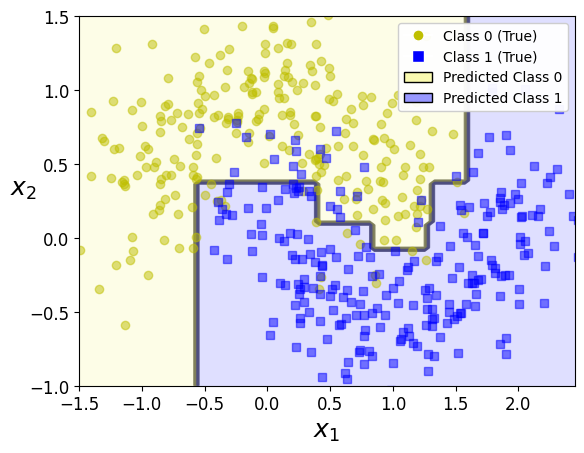

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME', learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


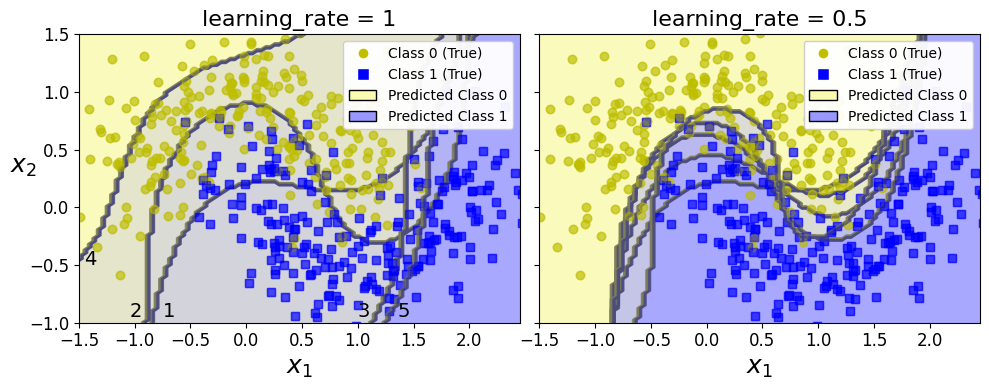

In [10]:
# Number of training samples (used for weight normalization)
m = len(X_train)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Logistic Regression: linear probabilistic classifier
log_clf = LogisticRegression(solver="lbfgs", random_state=42)

# Random Forest: bagged ensemble of decision trees
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Support Vector Classifier: margin-based classifier
svm_clf = SVC(gamma="scale", random_state=42)

# Hard voting ensemble: majority vote over class predictions
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

# Two subplots to compare different learning rates
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

# Iterate over (subplot index, learning_rate)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    # Initialize uniform sample weights: w_i = 1/m
    sample_weights = np.ones(m) / m
    
    plt.sca(axes[subplot])

    # Run 5 boosting rounds
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42) # Weak learner: low-capacity RBF SVM
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # Weighted error rate r = Σ w_i [y_i ≠ ŷ_i]
        
        # Learner weight α = η · log((1 − r) / r)
        alpha = learning_rate * np.log((1 - r) / r)

        # Increase weights of misclassified samples exponentially
        sample_weights[y_pred != y_train] *= np.exp(alpha)
        
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

## **Gradient Boosting**

Gradient Boosting works by **sequentially adding predictors to an ensemble, each one correcting its predecessor**. However, instead of tweaking the instance weights at every iteration like AdaBoost, this method tried to **fit the new predictor to the residual errors made by the previous predictor**

In [12]:
# Simple quadratic dataset
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [14]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [15]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [16]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

Saving figure gradient_boosting_plot


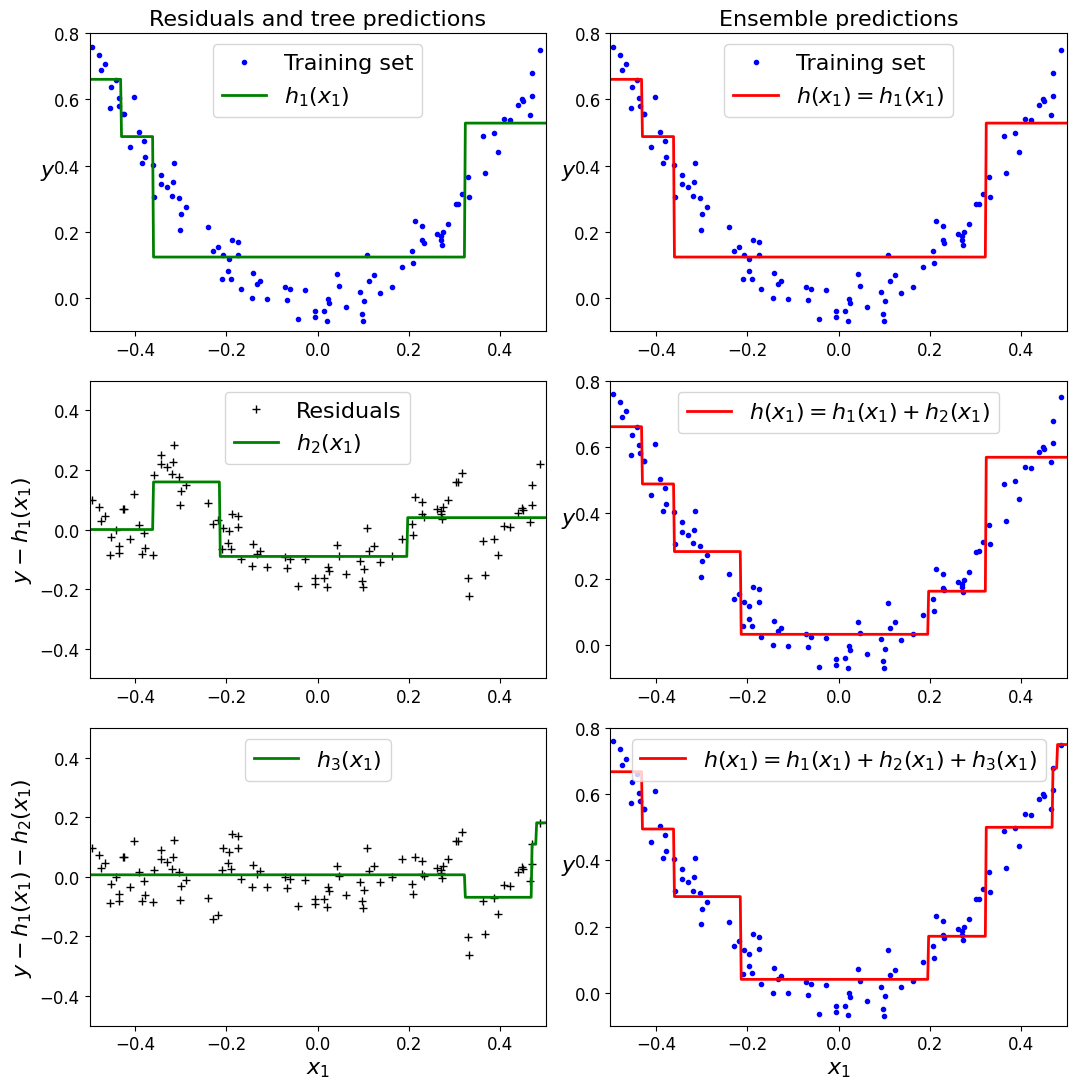

In [17]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)

    # Compute ensemble prediction by summing all weak learner outputs
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)

    # Plot original data points (true targets or residuals)
    plt.plot(X[:, 0], y, data_style, label=data_label)

    # Plot the current model or ensemble prediction curve
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)


plt.figure(figsize=(11,11))

# Plot the first tree predicting the original targets
plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

# Plot ensemble prediction after first boosting step
plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

# Plot second tree fitting the residuals of the first model
plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

# Plot ensemble prediction after two boosting steps
plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

# Plot third tree fitting residuals after two corrections
plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

# Plot final boosted model after three stages
plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

,loss,'squared_error'
,learning_rate,1.0
,n_estimators,3
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,2
,min_impurity_decrease,0.0
,init,None


Saving figure gbrt_learning_rate_plot


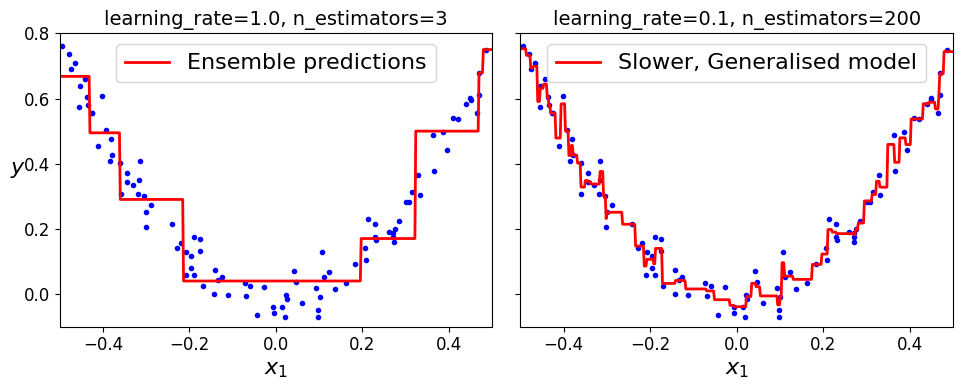

In [20]:
# Train a slower, more regularized gradient boosting model
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)

# Fit the boosted ensemble by sequentially minimizing squared loss
gbrt_slow.fit(X, y)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Slower, Generalised model")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()